In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import PIL
from tensorflow import keras
import tensorflow as tf
from keras import layers, optimizers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

## 1) The Dataset

#### Assuming you have a classification problem, is it binary, multi-class or multi-label?

I have a multi-class classification problem.

In [134]:
path = 'data/datasets-resized'

#Loading images from folder
import glob
import cv2
from skimage import io
from skimage.transform import resize

types = ['*.jpg', '*.jpeg']

#Creating list images and labels
images = []
labels = []

# Iterate the folder with glob
for fpath in glob.glob(path + '/*.jpg'): 
    # Read the image with OpenCV    
    im = cv2.imread(fpath) 
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # Assigning labels to images
    if 'glass' in fpath:
        label = 0 
    elif 'metal' in fpath:
        label = 1
    elif 'paper' in fpath:
        label = 2 
    elif 'cardboard' in fpath:
        label = 3
    elif 'plastic' in fpath:
        label = 4
        
    im_rgb = cv2.resize(im_rgb, (64, 64))
    #Put image array to X    
    #Put label to y    
    images.append(im_rgb)
    labels.append(label)
    
#Convert X and y to numpy array
images = np.array(images)
labels = np.array(labels)

#### Train/Test/validation sizes- Image size?

In [97]:
#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images,
                                                    labels,
                                                    test_size=1/10,
                                                    random_state=0)

#Convert labels to one-hot encoded matrix
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

print(X_train.shape, X_test.shape)

(2134, 64, 64, 3) (238, 64, 64, 3)


In [98]:
#Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=1/9,
                                                  random_state=0)
                                                  
print(X_train.shape, X_val.shape, X_test.shape)

(1896, 64, 64, 3) (238, 64, 64, 3) (238, 64, 64, 3)


In [99]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(1896, 64, 64, 3) (238, 64, 64, 3) (238, 64, 64, 3) (1896, 5) (238, 5) (238, 5)


#### Show a few examples per class

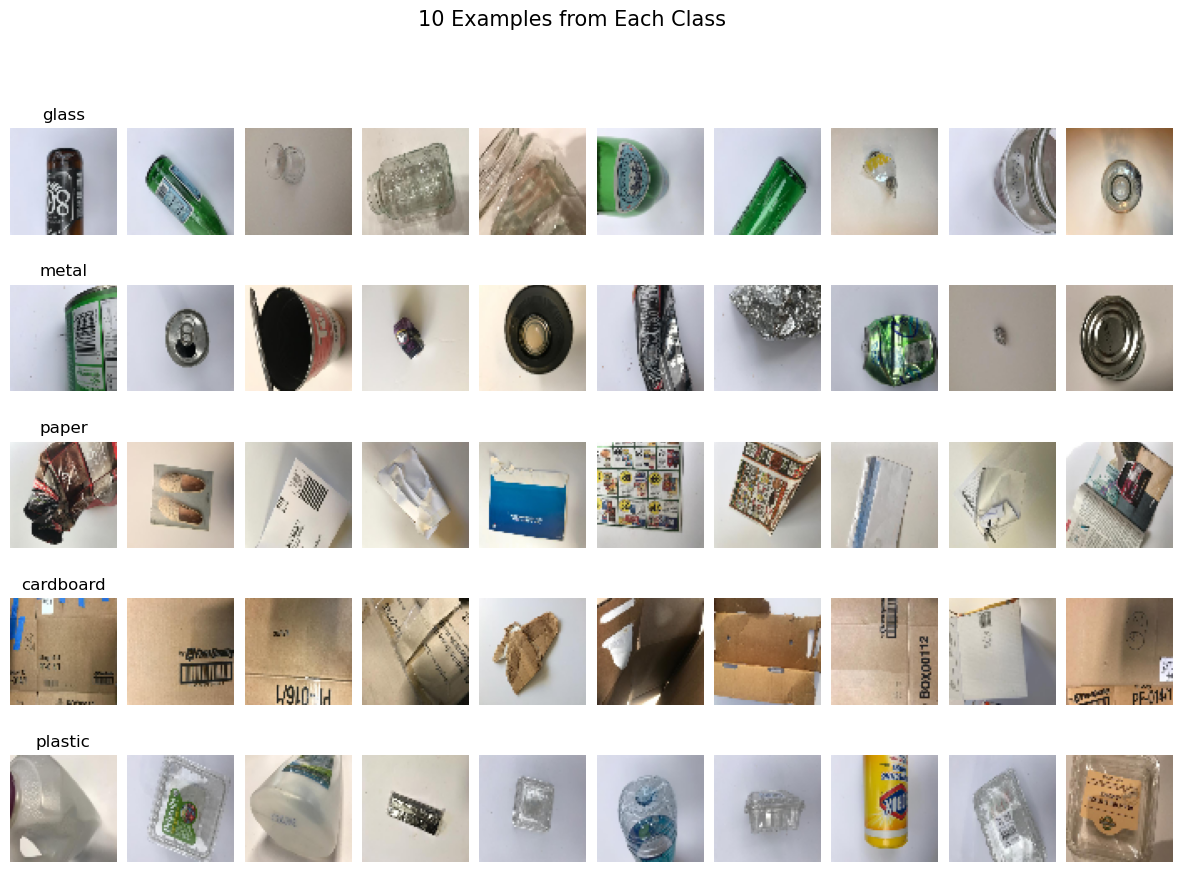

In [136]:
#Define class names
class_names = ['glass', 'metal', 'paper', 'cardboard', 'plastic']

#Set up the figure with 5 rows and 10 columns of subplots
fig, axes = plt.subplots(5, 10, figsize=(15, 10))

#Set the title of the figure
fig.suptitle('10 Examples from Each Class', fontsize=15)

#Iterate over the 5 classes
for i in range(5):
    #Get indices of images with current class label
    class_indices = np.where(labels == i)[0]
    #Randomly select 10 images from the current class
    sample_indices = np.random.choice(class_indices, size=10, replace=False)
    #Display the 10 images in a row
    for j, idx in enumerate(sample_indices):
        axes[i, j].imshow(images[idx])
        axes[i, j].axis('off')
        #Add the class name as a title to the first subplot in each row
        if j == 0:
            axes[i, j].set_title(class_names[i])
            
#Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

#### How many classes?

I have 5 different classes: glass, metal, paper, plastic and cardboard.

#### How many images per class?

In [101]:
for class_name in class_names:
    images = [f for f in os.listdir(path) if f.startswith(class_name) and os.path.isfile(os.path.join(path, f))]
    print(f"Class: {class_name}, Number of Images: {len(images)}")

Class: glass, Number of Images: 501
Class: metal, Number of Images: 409
Class: paper, Number of Images: 592
Class: cardboard, Number of Images: 408
Class: plastic, Number of Images: 462


#### How are the images labeled?

The filenames of the images carry the label information along with a unique identifier. For instance, an image depicting a cardboard material may have a filename such as "cardboard123.jpg", where "cardboard" represents the label and "123" is a unique identifier assigned to the image.

#### Dataset source(s)?

- https://github.com/garythung/trashnet
- imsitu dataset

## 2) Baselines

#### Random guess accuracy?

I have 5 classes so my random guess accuracy is 20%.

#### Human-Level Performance accuracy?

https://forms.office.com/e/3P7z31jPHu

Around 94.44-100%

#### Multilayer Perceptron accuracy?

In [102]:
#score = model.evaluate(X_test, y_test, verbose=0)
#print("Test accuracy:", score[1])

## 3) Preprocessing

#### Explain all the preprocessing steps you did.

The val. accuracy of the model was quite low (20-25%) so I have changed the CNN Architecure and I have changed the pixels from 128,128 to 64,64 which improved the val accuracy to around 60%. 

In [103]:
#Scale the data using
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

#Reshape the data back to its original shape
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)


## 4) CNN Architecure

In [104]:
#Define the model
model = Sequential()

#Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten layer
model.add(Flatten())

#Dense layers with dropout
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(5, activation='softmax'))

#Compile the model
model.compile(optimizer=Adam(learning_rate=0.001, decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Show model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 6, 6, 128)       

## 5) CNN training

#### Loss function/Optimizer (with its hyper-parameters)/Metrics

In [105]:
#Compile the model
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Training

In [106]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode='auto')
history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=100, callbacks=[early_stopping], validation_data=(X_test_scaled, y_test))

Epoch 1/100
60/60 [==============================] - 3s 39ms/step - loss: 5.1591 - accuracy: 0.2331 - val_loss: 3.1450 - val_accuracy: 0.2353
Epoch 2/100
60/60 [==============================] - 2s 33ms/step - loss: 2.5517 - accuracy: 0.3101 - val_loss: 2.0976 - val_accuracy: 0.3908
Epoch 3/100
60/60 [==============================] - 2s 38ms/step - loss: 1.9563 - accuracy: 0.3655 - val_loss: 1.7463 - val_accuracy: 0.3866
Epoch 4/100
60/60 [==============================] - 2s 39ms/step - loss: 1.7013 - accuracy: 0.4351 - val_loss: 1.5901 - val_accuracy: 0.4664
Epoch 5/100
60/60 [==============================] - 2s 39ms/step - loss: 1.6199 - accuracy: 0.4351 - val_loss: 1.5184 - val_accuracy: 0.4706
Epoch 6/100
60/60 [==============================] - 2s 32ms/step - loss: 1.4868 - accuracy: 0.4821 - val_loss: 1.4099 - val_accuracy: 0.4748
Epoch 7/100
60/60 [==============================] - 2s 35ms/step - loss: 1.4304 - accuracy: 0.5005 - val_loss: 1.3079 - val_accuracy: 0.5882
Epoch 

In [118]:
#Evaluate the model on the test data
val_loss, val_accuracy = model.evaluate(X_test_scaled, y_test)

#Print the validation accuracy as a percentage with two decimal places
print("Validation accuracy: {:.2%}".format(val_accuracy))

8/8 [==============================] - 0s 11ms/step - loss: 0.9964 - accuracy: 0.7647
Validation accuracy: 76.47%


#### Learning curves

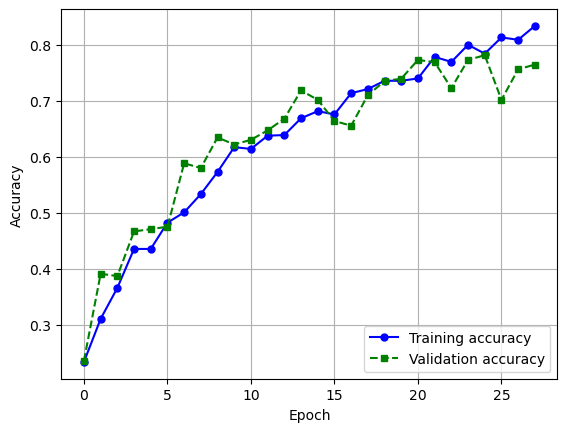

In [108]:
#Extract the training and validation accuracies for each epoch from the history object
val_acc = history.history['val_accuracy']
train_acc = history.history['accuracy']

#Set the number of epochs
num_epochs = len(val_acc)

#Plot the training and validation accuracies
plt.plot(range(num_epochs), train_acc, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.plot(range(num_epochs), val_acc, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

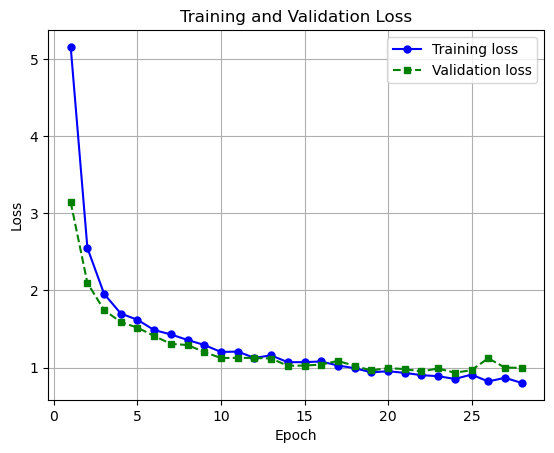

In [109]:
#Extract the training and validation losses for each epoch from the history object
val_loss = history.history['val_loss']
train_loss = history.history['loss']

#Plot the training and validation losses
plt.plot(range(1, len(train_loss) + 1), train_loss, color='blue', marker='o', markersize=5, label='Training loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, color='green', linestyle='--', marker='s', markersize=5, label='Validation loss')
plt.grid()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

(0.0, 6.0)

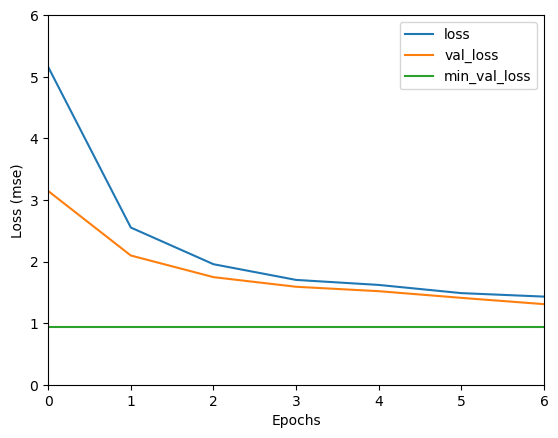

In [110]:
epoch_limits = [0, 6]
loss_limits = [0, 6]
plt.figure(dpi=100)
plt.xlabel('Epochs')
plt.ylabel('Loss (mse)')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(
    epoch_limits,
    [np.min(history.history['val_loss']), np.min(history.history['val_loss'])],
    label='min_val_loss')
plt.legend()

plt.ylim(loss_limits)
plt.xlim(epoch_limits)

## 6) Model performance

#### Metrics plots

8/8 [==============================] - 0s 10ms/step


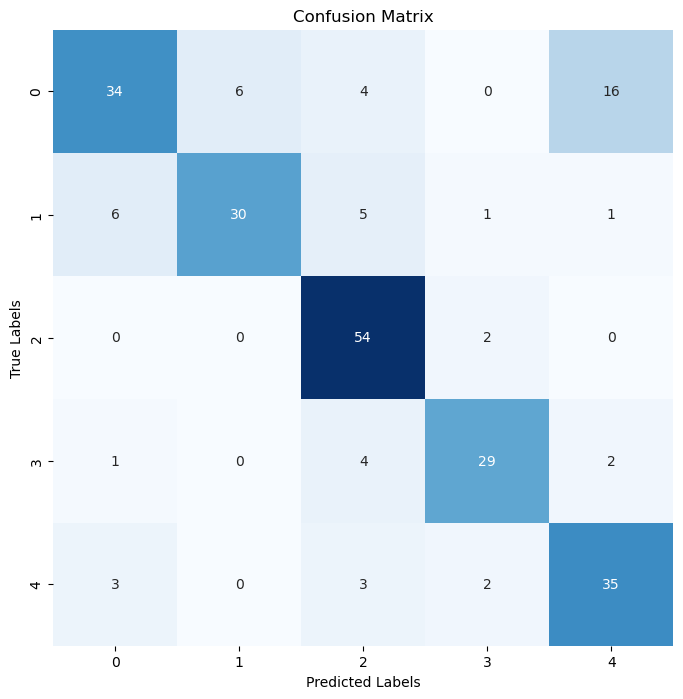

In [111]:
# Get the true labels and predicted labels
y_true = y_test
y_pred = model.predict(X_test_scaled)

# Convert the predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix using matplotlib
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [112]:
# Convert the matrix to a Pandas DataFrame
cm_df = pd.DataFrame(cm)


In [119]:
# Compute accuracy score
accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Print the accuracy score
print('Accuracy:', np.round(accuracy, 4))

# Compute precision score
precision = precision_score(y_true_labels, y_pred_labels, average='macro')

# Print the precision score
print('Precision:', np.round(precision, 4))

# Compute recall score
recall = recall_score(y_true_labels, y_pred_labels, average='macro')

# Print the recall score
print('Recall:', np.round(recall, 4))

# Compute F1 score
f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

# Print the F1 score
print('F1 Score:', np.round(f1, 4))

Accuracy: 0.7647
Precision: 0.7757
Recall: 0.7696
F1 Score: 0.7641


##### Baseline comparison

In [126]:
#Basline model
pd.DataFrame({'Random guess (%)': [20],
              'CNN(%)':[np.round(accuracy, 3)*100],
              'HLP(%)':[94.5]})

,Random guess (%),CNN(%),HLP(%)
0,20,76.5,94.5


## 7) Error analysis

#### Top error interpretation

In [129]:

y_pred = model.predict(X_test_scaled)

# Convert the predictions and true labels to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Find the misclassified examples
misclassified_idxs = np.where(y_pred_labels != y_true_labels)[0]

# Print the number of misclassified examples
print(f"Number of misclassified examples: {len(misclassified_idxs)}")

# Print the indices of the misclassified examples
print("Misclassified indices: ", misclassified_idxs)

# Print the predicted labels and true labels for the misclassified examples
for idx in misclassified_idxs:
    print(f"Predicted label: {y_pred_labels[idx]}, True label: {y_true_labels[idx]}")

8/8 [==============================] - 0s 10ms/step
Number of misclassified examples: 56
Misclassified indices:  [  3   4  10  15  20  23  26  28  36  44  46  51  55  59  60  63  64  69
  72  77  78  79  83  84  86  87  92  94  95  99 104 110 114 117 126 129
 135 140 153 156 159 163 165 167 171 172 173 182 187 192 197 204 205 215
 229 233]
Predicted label: 1, True label: 0
Predicted label: 4, True label: 0
Predicted label: 4, True label: 0
Predicted label: 2, True label: 3
Predicted label: 2, True label: 4
Predicted label: 4, True label: 0
Predicted label: 3, True label: 1
Predicted label: 2, True label: 1
Predicted label: 2, True label: 1
Predicted label: 1, True label: 0
Predicted label: 2, True label: 3
Predicted label: 0, True label: 1
Predicted label: 4, True label: 0
Predicted label: 4, True label: 0
Predicted label: 0, True label: 1
Predicted label: 2, True label: 1
Predicted label: 4, True label: 1
Predicted label: 4, True label: 0
Predicted label: 3, True label: 2
Predicted la

The error analysis shows that the model misclassified 56 out of 240 examples, resulting in an accuracy of 76.67%. Looking at the misclassified indices, it can be seen that the model predicted label 4 (plastic) quite often when it was not the true label. 